# CropSAR_px: openEO UDP usage
In this notebook, the usage of the CropSAR_px process in openEO will be demonstrated.

In [1]:
import openeo
import datetime
import tempfile
import os
import xarray
import matplotlib.pyplot as plt

## Set up openEO connection

In [2]:
connection = openeo.connect("https://openeo-dev.vito.be").authenticate_basic()

## Retrieve `CropSAR_px` process
Look for `CropSAR_px` process in the `vito` namespace. Especially the *Parameters* section of the process is of interest.

In [3]:
connection.list_processes("vito")

[{'description': 'Yield potential maps show the spatial variation in crop performance within a field over an entire season. A farmer can\nuse these yield potential maps to review a field’s history over time. Recurring good or bad zones are usually caused by\ndifferences in soil, surrounding vegetation or hydrology, while more abrupt and unexpected field variation can be due to\nextreme weather events such as drought, hail, storm or flood damage. The maps can also be used as input for\nvariable-rate fertilization or irrigation, to adjust the dose of fertilizer or water according to the spatial variation\nwithin the field.\n\nThe base index for the calculation of the yield potential maps is fAPAR, the fraction of absorbed photosynthetically\nactive radiation, derived from Sentinel-2 satellite images with a spatial resolution of 10m. To calculate the maps we\nuse all cloud free images acquired in the period between full emergence and onset of crop senescence, when the the\nfield’s average fAPAR value > 0.5.\n\nFor these images we compare the fAPAR value of each pixel to the median fAPAR value of the field (pixel values are\nexpressed as % of the median) and then calculate the average deviation over the season. These average deviations are\nmade available as geotiff images.\n\n![Yield Potential Map - Average deviations](https://artifactory.vgt.vito.be:443/auxdata-public/Nextland/services/descriptions/yieldpotentialmap/yieldmap_raw.png)\n\n*Example of a yield potential map (average deviations)*\n\nFinally, the deviations are classified it into five categories according to their relevance and color maps are\ngenerated.\n\n| Range | Class            | Color           |\n| --- |------------------|-----------------|\n| <92.5% | 1                | red             |\n| 92.5-97.5% | 2                | oranje          |\n| 97.5-102.5% | 3                | light green     |\n| 102.5-107.5% | 4                | dark green      |\n| \\>107.5% | 5| ‘darkest’ green |\n\nIn the red and orange zones lower fAPAR values are found throughout the season while in the green and dark green zones\nthe fAPAR values are (much) higher than the median value. We assume that the yield potential is higher in the dark green\nzones compared to the orange and red zones.\n\n![Yield Potential Map - Categorized](https://artifactory.vgt.vito.be:443/auxdata-public/Nextland/services/descriptions/yieldpotentialmap/yieldmap_categories.png)\n![Yield Potential Map - Legend](https://artifactory.vgt.vito.be:443/auxdata-public/Nextland/services/descriptions/yieldpotentialmap/yieldmap_legend.png)\n\n*Example of a yield potential color map (average deviations classified into 5 categories)*\n',
  'id': 'yieldpotentialmap_shub',
  'parameters': [{'description': 'Left-closed temporal interval, i.e. an array with exactly two elements:\n\n1. The first element is the start of the temporal interval. The specified instance in time is **included** in the interval.\n2. The second element is the end of the temporal interval. The specified instance in time is **excluded** from the interval.\n\nThe specified temporal strings follow [RFC 3339](https://www.rfc-editor.org/rfc/rfc3339.html). Also supports open intervals by setting one of the boundaries to `null`, but never both.',
    'name': 'date',
    'schema': {'examples': [['2015-01-01T00:00:00Z', '2016-01-01T00:00:00Z'],
      ['2015-01-01', '2016-01-01']],
     'items': {'anyOf': [{'format': 'date-time',
        'subtype': 'date-time',
        'type': 'string'},
       {'format': 'date', 'subtype': 'date', 'type': 'string'},
       {'maxLength': 4,
        'minLength': 4,
        'pattern': '^\\d{4}$',
        'subtype': 'year',
        'type': 'string'},
       {'type': 'null'}]},
     'maxItems': 2,
     'minItems': 2,
     'subtype': 'temporal-interval',
     'type': 'array'}},
   {'description': 'Feature collection of fields for which to generate the yield potential map',
    'name': 'polygon',
    'schema': {'subtype': 'geojson', 'ty

## Use process to get DataCube
Get output datacube from process by passing in the process parameters:
**Mandatory**
- `geometry`: GeoJSON feature
- `startdate`: start of temporal interval
- `enddate`: end of temporal interval

**Optional**
- `nrt`: only use prior information (default: false)
- `inpaint_only`: only predict areas with no ground truth data (default: true)
- `output_mask`: output ground truth mask (deafult: false)
- `drop_dates`: list of dates

In [4]:
geometry = {
    "type": "Polygon",
    "coordinates": [
        [
            [
                5.034656524658203,
                51.20946446493662
            ],
            [
                5.080232620239258,
                51.20946446493662
            ],
            [
                5.080232620239258,
                51.234084900561015
            ],
            [
                5.034656524658203,
                51.234084900561015
            ],
            [
                5.034656524658203,
                51.20946446493662
            ]
        ]
    ]
}

start = datetime.date(2021, 7, 1)
end = start + datetime.timedelta(days=31)
date_format = "%Y-%m-%d"

datacube = connection.datacube_from_process(
    "CropSAR_px", namespace="vito",
    geometry=geometry,
    startdate=start.strftime(date_format),
    enddate=end.strftime(date_format),
    output_mask=True,
    drop_dates=[date.strftime(date_format) for date in [datetime.date(2021, 7, x) for x in range(3, 12)]],
    version=2,
    model_path="tmp/model/cnn_transformer/",
    path_extras=["tmp/env/env/"]
)

/home/stijn/PycharmProjects/cropsar_px/venv/lib/python3.8/site-packages/openeo/metadata.py:255: UserWarning: No cube:dimensions metadata
  complain("No cube:dimensions metadata")


## Execute job and download result

In [5]:
job = datacube.execute_batch(
    title="CropSAR_px Notebook",
    out_format="GTIFF",
    job_options={
        "executor-cores": "8",
        "task-cpus": "8",
        "executor-memoryOverhead": "2g",
        "udf-dependency-archives": [
            "https://artifactory.vgt.vito.be/auxdata-public/cropsar_px/20230504T175919_cnn_transformer.zip#tmp/model/cnn_transformer",
            "https://artifactory.vgt.vito.be/auxdata-public/cropsar_px/env.tar.gz#tmp/env"
        ]
    }
)


0:00:00 Job 'j-bf504332869d48f1b745adafb2bd2e61': send 'start'
0:00:52 Job 'j-bf504332869d48f1b745adafb2bd2e61': queued (progress N/A)
0:01:30 Job 'j-bf504332869d48f1b745adafb2bd2e61': queued (progress N/A)
0:01:37 Job 'j-bf504332869d48f1b745adafb2bd2e61': queued (progress N/A)
0:01:45 Job 'j-bf504332869d48f1b745adafb2bd2e61': queued (progress N/A)
0:01:55 Job 'j-bf504332869d48f1b745adafb2bd2e61': queued (progress N/A)
0:02:08 Job 'j-bf504332869d48f1b745adafb2bd2e61': queued (progress N/A)
0:02:23 Job 'j-bf504332869d48f1b745adafb2bd2e61': queued (progress N/A)
0:02:43 Job 'j-bf504332869d48f1b745adafb2bd2e61': queued (progress N/A)
0:03:10 Job 'j-bf504332869d48f1b745adafb2bd2e61': queued (progress N/A)
0:03:40 Job 'j-bf504332869d48f1b745adafb2bd2e61': queued (progress N/A)
0:04:18 Job 'j-bf504332869d48f1b745adafb2bd2e61': queued (progress N/A)
0:05:05 Job 'j-bf504332869d48f1b745adafb2bd2e61': queued (progress N/A)
0:06:03 Job 'j-bf504332869d48f1b745adafb2bd2e61': queued (progress N/A)
0

In [6]:
results = job.get_results()
output_directory = tempfile.TemporaryDirectory()
files = results.download_files(output_directory.name)
files = [file for file in files if os.path.splitext(file)[1] == ".tif"]

## Explore results
The first band of the output will be the CropSAR_px NDVI prediction.
The second band contains the Sentinel-2 input mask (if requested via `output_mask`). The values of this mask have the following meaning:
 - 0: no data (clouds, ...)
 - 1: ground truth data
 - 2: manually masked (via `drop_dates` parameter)

### Scaling
The output contains NDVI values in the interval [-0.08; 1] scaled to the byte output range [0; 250].
If you want to convert back to the physical values, you have to use the following scaling factor: `x * 0.00432 - 0.08`


/tmp/ipykernel_15335/1062817384.py:6: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xarray.open_rasterio(file)
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
/tmp/ipykernel_15335/1062817384.py:6: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xarray.open_rasterio(file)
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
/tmp/ipykernel_15335/1062817384.py:6: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about t

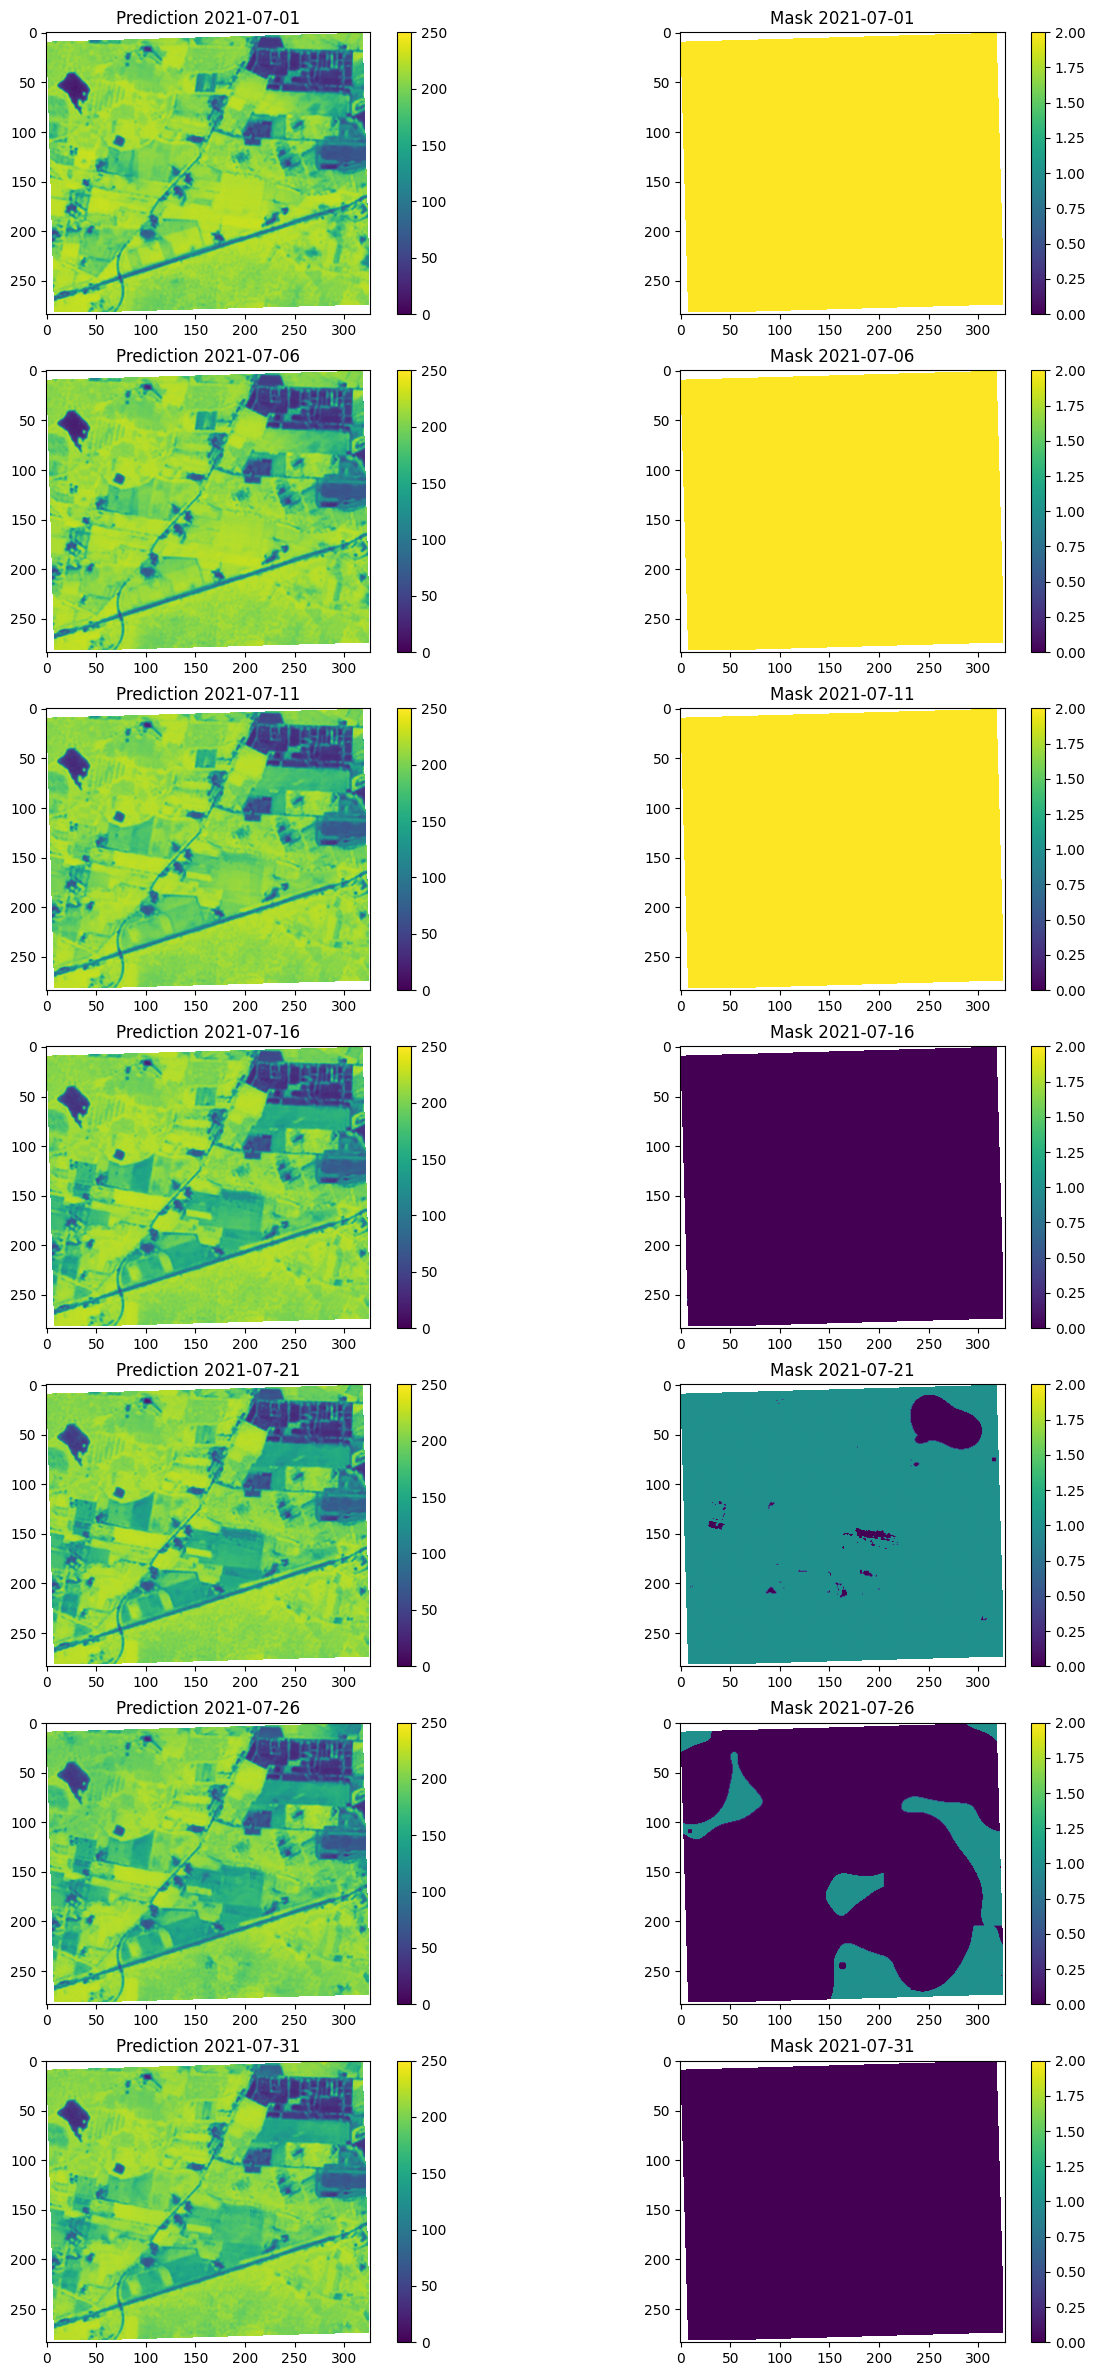

In [7]:
nrows = len(files)
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 30))

for i, file in enumerate(files):
    ds = xarray.open_rasterio(file)
    ds = ds.where(ds != 255)  # filter no data value

    date = os.path.splitext(os.path.basename(file))[0].split('_')[-1][:-1]

    im_pred = axs[i, 0].imshow(ds[0], vmin=0, vmax=250)
    axs[i, 0].set_title(f"Prediction {date}")
    fig.colorbar(im_pred, ax=axs[i, 0])

    im_mask = axs[i, 1].imshow(ds[1], vmin=0, vmax=2)
    axs[i, 1].set_title(f"Mask {date}")
    fig.colorbar(im_mask, ax=axs[i, 1])

plt.show()

In [15]:
# clean up temporary output directory
output_directory.cleanup()